In [1]:
import os
import glob
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, f1_score, matthews_corrcoef, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras.callbacks import EarlyStopping

In [2]:
import os
import numpy as np
import pandas as pd
import cv2

# Function to create directory if it does not exist
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Base path to the synthetic dataset
base_path = '/kaggle/input/movement-dataset-entire/synthetic_dataset'
# Path to save the frames
frames_base_dir = '/kaggle/working/frames'

test_dir ='/kaggle/input/entire-test-movement-dataset/Abhishek_prashant_input_data'
frame_test_dir ='/kaggle/working/test/frames'

# Create the directory to save frames
create_directory(frames_base_dir)
create_directory(frame_test_dir)
# Initialize lists to hold the dataset

In [3]:
import os
import cv2
import numpy as np
import pandas as pd

# Initialize lists to store paths and labels
train_image_paths = []
train_foot_contacts = []

# Set a limit on the number of frames to process
frame_limit = 6000
total_frames = 0
stop_processing = False

# Loop through each person folder
for person_folder in os.listdir(base_path):
    if stop_processing:  # Check if processing should stop
        break

    person_path = os.path.join(base_path, person_folder)
    if os.path.isdir(person_path):
        # Loop through each activity folder
        for activity_folder in os.listdir(person_path):
            if stop_processing:  # Check if processing should stop
                break

            activity_path = os.path.join(person_path, activity_folder)
            if os.path.isdir(activity_path):
                # Path to the .npy file containing foot contact data
                foot_contacts_path = os.path.join(activity_path, 'foot_contacts.npy')
                
                if os.path.exists(foot_contacts_path):
                    # Load foot contact labels
                    foot_contact_labels = np.load(foot_contacts_path)
                    
                    # Construct the pattern to match video files
                    video_pattern = f'{activity_folder}_view0.mp4'
                    
                    # Loop through each video file in the activity folder
                    for video_file in os.listdir(activity_path):
                        if stop_processing:  # Check if processing should stop
                            break

                        if video_file == video_pattern:
                            video_path = os.path.join(activity_path, video_file)
                            
                            # Directory to save the frames of the current video
                            frames_dir = os.path.join(frames_base_dir, f'{person_folder}_{activity_folder}')
                            os.makedirs(frames_dir, exist_ok=True)  # Create directory if it doesn't exist
                            
                            # Capture the video from the file
                            cap = cv2.VideoCapture(video_path)
                            if not cap.isOpened():
                                print(f"Error: Could not open video {video_path}")
                                continue
                            
                            frame_count = 0
                            while cap.isOpened():
                                ret, frame = cap.read()
                                if not ret:
                                    break
                                
                                # Save frame as image
                                frame_filename = f'frame_{frame_count:04d}.jpg'
                                frame_path = os.path.join(frames_dir, frame_filename)
                                cv2.imwrite(frame_path, frame)
                                
                                # Append frame path and corresponding foot contact label to lists
                                if frame_count < len(foot_contact_labels):
                                    train_image_paths.append(frame_path)
                                    train_foot_contacts.append(foot_contact_labels[frame_count])
                                
                                frame_count += 1
                                total_frames += 1
                                
                                # Check if the frame limit is reached
                                if total_frames >= frame_limit:
                                    stop_processing = True  # Set flag to stop further processing
                                    print("Frame limit reached.")
                                    break
                            
                            # Release the capture
                            cap.release()
                            print(f"Processed {frame_count} frames from {video_file}")

# Create DataFrame
data = {
    'filename': train_image_paths,
    'left_heel': [label[0] for label in train_foot_contacts],
    'left_toe': [label[1] for label in train_foot_contacts],
    'right_heel': [label[2] for label in train_foot_contacts],
    'right_toe': [label[3] for label in train_foot_contacts]
}

left_leg_values = [label[0] & label[1] for label in train_foot_contacts]
right_leg_values = [label[2] & label[3] for label in train_foot_contacts]

data_left_leg = {
    'filename': train_image_paths,
    'left_leg': left_leg_values
}

data_right_leg = {
    'filename': train_image_paths,
    'right_leg': right_leg_values
}

train_left_df = pd.DataFrame(data_left_leg)
train_right_df = pd.DataFrame(data_right_leg)
train_df = pd.DataFrame(data)

print(train_df.head())
print(train_right_df.head())
print(train_left_df.head())
print(len(train_df))

Processed 60 frames from 449_swing_dancing_view0.mp4
Processed 60 frames from 1847_baseball_walk_in_view0.mp4
Processed 60 frames from 378_salsa_dancing_view0.mp4
Processed 60 frames from 321_boxing_view0.mp4
Processed 60 frames from 1854_baseball_step_up_to_bat_view0.mp4
Processed 60 frames from 43_walking_view0.mp4
Processed 60 frames from 189_baseball_pitching_view0.mp4
Processed 60 frames from 391_salsa_dancing_view0.mp4
Processed 60 frames from 2166_standing_turn_90_right_view0.mp4
Processed 60 frames from 376_salsa_dancing_view0.mp4
Processed 60 frames from 1855_baseball_milling_idle_view0.mp4
Processed 60 frames from 2165_standing_turn_90_left_view0.mp4
Processed 60 frames from 448_salsa_dancing_view0.mp4
Processed 60 frames from 392_salsa_dancing_view0.mp4
Processed 60 frames from 326_samba_dancing_view0.mp4
Processed 60 frames from 1851_baseball_hit_view0.mp4
Processed 60 frames from 1529_quarterback_pass_view0.mp4
Processed 60 frames from 328_boxing_view0.mp4
Processed 60 fra

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import os

images = []
labels = []

# Define image size and color channels (adjust according to your needs)
img_width, img_height = 256, 256
channels = 3
num_classes = 2
input_shape = (256, 256, 3)

# Preprocess images and labels
for index, row in train_right_df.iterrows():
    img_path = row['filename']
    label = row['right_leg']  # 0 or 1

    # Load and preprocess the image
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
#x_train = images
#y_train = labels

# Print the shapes
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
#print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4800, 256, 256, 3) - y_train shape: (4800,)


In [5]:
import os
import cv2
import pandas as pd
test_image_paths = []
test_foot_contacts = []
# Function to create a directory if it doesn't exist
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Directories
test_dir = '/kaggle/input/entire-test-movement-dataset'
frame_test_dir = '/kaggle/working/test/frames'
create_directory(frame_test_dir)

# Paths to MP4 files and corresponding ground truth CSV files
video_paths = [
    #'/kaggle/input/entire-test-movement-dataset/Abhishek_prashant_input_data/Abhishek/jumping_abhishek.mp4',
    '/kaggle/input/entire-test-movement-dataset/Abhishek_prashant_input_data/Prashant/jumping_video_prashant_gupta.mp4'
]

ground_truth_paths = [
    #'/kaggle/input/entire-test-movement-dataset/Abhishek_prashant_input_data/Abhishek/ground_truth/abhishek jumping video.csv',
    '/kaggle/input/entire-test-movement-dataset/Abhishek_prashant_input_data/Prashant/ground_truth/prashant jumping video.csv'
]

# Initialize lists for DataFrame
test_image_paths = []
test_foot_contacts = []

# Set a limit on the number of frames to process
MAX_FRAMES = 200
total_frames_processed = 0

# Process each video and its corresponding ground truth
for video_path, gt_path in zip(video_paths, ground_truth_paths):
    if total_frames_processed >= MAX_FRAMES:
        break

    # Read the ground truth CSV
    ground_truth_df = pd.read_csv(gt_path)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        continue
    
    # Extract video identifier (base name of video file without extension)
    video_id = os.path.splitext(os.path.basename(video_path))[0]
    
    frame_count = 0
    while cap.isOpened():
        if total_frames_processed >= MAX_FRAMES:
            break

        ret, frame = cap.read()
        if not ret:
            break
        
        # Save frame as image with video identifier
        frame_filename = f'{video_id}_frame_{total_frames_processed:04d}.jpg'
        frame_path = os.path.join(frame_test_dir, frame_filename)
        cv2.imwrite(frame_path, frame)
        
        # Get foot contact data for the current frame
        if frame_count < len(ground_truth_df):
            left_foot = ground_truth_df.iloc[frame_count]['left_foot']
            right_foot = ground_truth_df.iloc[frame_count]['right_foot']
            test_image_paths.append(frame_path)
            test_foot_contacts.append([left_foot, right_foot])
        
        frame_count += 1
        total_frames_processed += 1

    cap.release()
    print(f"Processed {frame_count} frames from {video_path}")

    if total_frames_processed >= MAX_FRAMES:
        break

# Create DataFrames
test_df = pd.DataFrame({
    'filename': test_image_paths,
    'left_leg': [label[0] for label in test_foot_contacts],
    'right_leg': [label[1] for label in test_foot_contacts]
})

# Create DataFrames for left and right foot separately if needed
test_left_df = pd.DataFrame({
    'filename': test_image_paths,
    'left_leg': [label[0] for label in test_foot_contacts]
})

test_right_df = pd.DataFrame({
    'filename': test_image_paths,
    'right_leg': [label[1] for label in test_foot_contacts]
})

# Print the first few rows of each DataFrame
print(test_df.head())
print(test_left_df.head())
print(test_right_df.head())

Processed 200 frames from /kaggle/input/entire-test-movement-dataset/Abhishek_prashant_input_data/Prashant/jumping_video_prashant_gupta.mp4
                                            filename  left_leg  right_leg
0  /kaggle/working/test/frames/jumping_video_pras...         1          1
1  /kaggle/working/test/frames/jumping_video_pras...         1          1
2  /kaggle/working/test/frames/jumping_video_pras...         1          1
3  /kaggle/working/test/frames/jumping_video_pras...         1          1
4  /kaggle/working/test/frames/jumping_video_pras...         1          1
                                            filename  left_leg
0  /kaggle/working/test/frames/jumping_video_pras...         1
1  /kaggle/working/test/frames/jumping_video_pras...         1
2  /kaggle/working/test/frames/jumping_video_pras...         1
3  /kaggle/working/test/frames/jumping_video_pras...         1
4  /kaggle/working/test/frames/jumping_video_pras...         1
                                      

In [6]:
# Load and preprocess test images and labels
test_images = []
test_labels = []

for index, row in test_right_df.iterrows():
    img_path = row['filename']  # Adjust the column name if it's different
    label = row['right_leg']    # 0 or 1

    # Load and preprocess the image
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    test_images.append(img_array)
    test_labels.append(label)

# Convert lists to numpy arrays
x_test1 = np.array(test_images)
y_test1 = np.array(test_labels)

# Print the shape of the test dataset
print(f"test_images shape: {x_test.shape} - test_labels shape: {y_test.shape}")


test_images shape: (1200, 256, 256, 3) - test_labels shape: (1200,)


In [7]:
import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 400  # For real training, use num_epochs=100. 10 is a test value
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
] 

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 256 X 256
Patch size: 16 X 16
Patches per image: 256
Elements per patch: 768


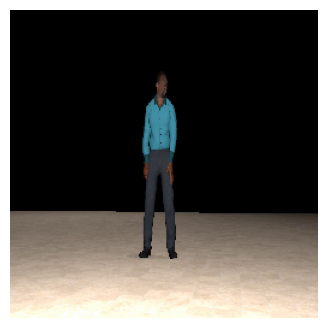

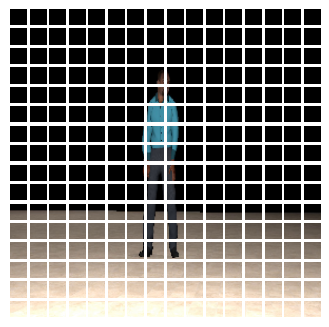

In [11]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [13]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/400
270/270 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.5675 - loss: 4.9925 - top-5-accuracy: 1.0000 - val_accuracy: 0.6396 - val_loss: 0.6806 - val_top-5-accuracy: 1.0000
Epoch 2/400
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.6019 - loss: 0.6908 - top-5-accuracy: 1.0000 - val_accuracy: 0.6625 - val_loss: 0.6441 - val_top-5-accuracy: 1.0000
Epoch 3/400
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.6156 - loss: 0.6754 - top-5-accuracy: 1.0000 - val_accuracy: 0.6479 - val_loss: 0.6492 - val_top-5-accuracy: 1.0000
Epoch 4/400
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6221 - loss: 0.6849 - top-5-accuracy: 1.0000 - val_accuracy: 0.6667 - val_loss: 0.6140 - val_top-5-accuracy: 1.0000
Epoch 5/400
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6214 - loss: 0.6697 - top-5-accuracy: 1.0000 - val_accuracy: 0.6687 - val_loss: 0.6211 - val_top-5-accuracy: 1.0000
Epoch 6/400
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6383 -

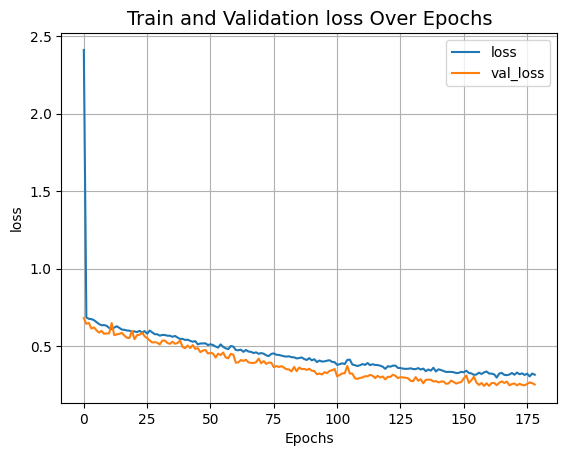

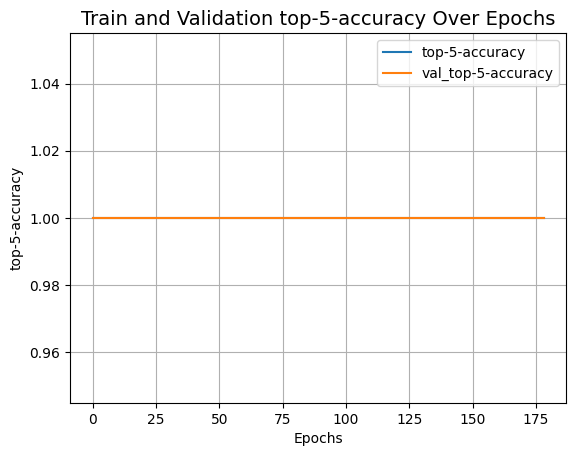

In [14]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/kaggle/working/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback,early_stopping_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test1, y_test1)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")